# Figure 4

## Imports

In [1]:
from brian2 import *
prefs.codegen.target = 'numpy'

import itertools
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pickle
import glob

from encoder_class.phase_encoder import PhaseEncoder, run_simulation
from encoder_class.theoretical_functions import phi_of_I_lin, phi_of_I, mixture, zero_order_H, gauss_H, approx_mutual_I, bins_mutual_I
from encoder_class.encoder_functions import model_sigma
from encoder_class.plot_functions import plt_fig_4b, plt_fig_4c, plt_fig_4d

## Network Setup

In [2]:
# a network identical to that in grid_freqNoise_cluster.py is initialized

M = 10
N = 1

model_params = {}
model_params["tau_m"] = 24*ms
model_params["R_m"] = 142e6*ohm
model_params["v_thres"] = 15*mV
model_params["v_rest"] = 0*mV
model_params["v_reset"] = 0*mV
model_params["tau_ref"] = 0*ms
model_params["v_0"] = 0*mV
model_params["noise_frac"] = 0


oscillation_params = {}
oscillation_params["I_osc"] = 40*pA
oscillation_params["f"] = 5*Hz

input_params = {}
input_params["automatic_range"] = True
input_params["corr_frac"] = 0.2
input_params["I_min"] = 75*pA
input_params["I_max"] = 130*pA

simulation_params = {}
simulation_params["method"] = "euler"
simulation_params["num_oscillations"] = 4
simulation_params["monitor_spikes"] = True
simulation_params["monitor_voltage"] = False
simulation_params["dt"] = 0.05*ms
simulation_params["record_dt"] = 0.5*ms

In [22]:
## parameter space is also initialized identically

partition = 100

noise_lims = [0., 0.4]
f_lims = [1*Hz, 50*Hz]

encoder = PhaseEncoder(num_ensembles=M, ensemble_size=N, model_params=model_params, 
                       oscillation_params=oscillation_params, input_params=input_params,
                       simulation_params=simulation_params, rnd_seed=0)

noise_fracs = np.linspace(noise_lims[0], noise_lims[1], partition)
fs = np.linspace(f_lims[0], f_lims[1], partition)
stoch_sigmas = np.array(list(map(lambda eta: model_sigma(eta, encoder), noise_fracs)))

experiments = itertools.product(noise_fracs, fs)
num_experiments = len(list(experiments))

## Load and Process Data

In [23]:
#load data generated with grid_freqNoise_cluster.py

exp_MI_matrix = []
files = [file for file in sorted(glob.glob('cluster_sims/Data_290622/Data_Noise/*.pickle'))]

for filename in files:
    with open(filename, 'rb') as handle:
        result = pickle.load(handle)
        exp_MI_matrix.append( result['MI'] )
        
exp_MI_matrix = np.clip(np.reshape(exp_MI_matrix, (100,100)), 0, None)
fs_matrix = np.log2(np.exp(1))*np.transpose(np.repeat(fs, partition).reshape(partition, partition))/Hz
#fs_matrix = np.transpose(np.repeat(fs, partition).reshape(partition, partition))/Hz

exp_bits_second = fs_matrix*exp_MI_matrix


#get normalized values
exp_normalized = np.zeros((partition,partition))   
for index, row in enumerate(exp_bits_second):
    exp_normalized[index, :] = row/np.max(row)

## Figure 4B

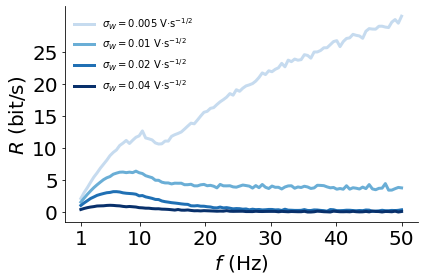

In [28]:
plt.rcParams['figure.figsize'] = [6.0, 4.0]
num_freqs = 5
num_noises = 5
f_cm = cm.Greens(np.linspace(0, 1, num_freqs))
noise_cm = cm.Blues(np.linspace(0, 1, num_noises))

for i,index in enumerate([14, 28, 50, 99]):
#for i,index in enumerate([28, 50, 99]):
    noise_label = r"$\sigma_W = $" + str(eval("%.0e" % (stoch_sigmas[index]))) + r" V·s$^{-1/2}$"
    plt.plot(fs, exp_bits_second[index,:], color=noise_cm[i + 1], label=noise_label, linewidth=3)

plt_fig_4b()

plt.savefig('Figures/Figure_4b.svg', dpi=600)
plt.savefig('Figures/Figure_4b.png', dpi=600)

## Figure 4C

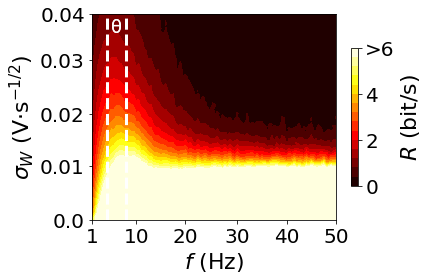

In [6]:
#plt.imshow(exp_bits_second, cmap='hot', vmin=0, vmax=10, origin='lower')
plt.contourf(np.clip(exp_bits_second, a_min=None, a_max=6), vmin=0, vmax=6, cmap='hot',levels=15)

plt_fig_4c(fs, stoch_sigmas)
theta_range = [4, 8]
th_char_index = (theta_range[1] + theta_range[0])//2 + 2
plt.text(x=th_char_index, y=90, s='θ', fontsize=18, color='white')
plt.savefig('Figures/Figure_4c.svg', dpi=600)
plt.savefig('Figures/Figure_4c.png', dpi=600)
plt.show()

## Figure 4D

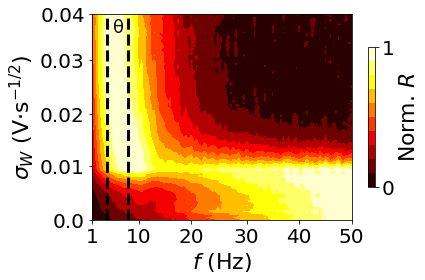

In [7]:
plt.contourf(exp_normalized, cmap='hot', levels=10, vmin=0)

plt_fig_4d(fs, stoch_sigmas)

plt.savefig('Figures/Figure_4d.svg', dpi=600)
plt.savefig('Figures/Figure_4d.png', dpi=600)
plt.show()